# augmentation
* Efficient-net B2
    - layernorm
    - dropout
* Augmentation
    - Transpose # 행렬 스왑
    - HorizontalFlip # 좌우 반전
    - VerticalFlip # 상하 반전
    - ShiftScaleRotate # 랜덤하게 옮기고, scale, 회전
    - HueSaturationValue # 빛깔, 색조, 값 변환
    - RandomBrightnessContrast # 명도 대비
    - ChannelShuffle # RGB 채널 간 shuffle
    - CoarseDropout # 조그마한 검은 사각형 영역 추가
* result
    - train loss : 0.50340
    - validation loss : 1.15463
    - f1 score : 0.69038
    - epoch : 51
    - public 점수 : 0.6585521452
    - privite 점수 : 0.6482789215


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install timm

In [3]:
import gc
import random
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
CFG = {
    'IMG_SIZE': 260,
    'EPOCHS': 1000,
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 32,
    'PATIENCE': 10,
    'FILENAME': 'augmentation',
    'SEED': 6
}

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [7]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Project/CV/dataset/'
else:
    data_path = '../../data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [9]:
artists = df.groupby('artist')[['id']].count().rename(columns={'id':'count'}).reset_index()

In [10]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [11]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG['SEED'])

In [12]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
1,1,./train/0001.jpg,48
3,3,./train/0003.jpg,10
4,4,./train/0004.jpg,24
6,6,./train/0006.jpg,43


In [13]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
2,2,./train/0002.jpg,7
5,5,./train/0005.jpg,38
10,10,./train/0010.jpg,6
11,11,./train/0011.jpg,1
18,18,./train/0018.jpg,33


In [14]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [15]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [16]:
from torchvision.transforms import ToTensor

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms if transforms else ToTensor()

    def __getitem__(self, index):
        img_path = self.img_paths[index]

        try:
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"경로 {img_path}의 이미지를 불러올 수 없습니다.")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']

            if self.labels is not None:
                label = self.labels[index]
                return image, label
            else:
                return image

        except Exception as e:
            print(f"경로 {img_path}의 이미지를 불러오는 중 오류가 발생했습니다: {e}")
            # 오류를 graceful하게 처리: 기본 이미지와 레이블 반환
            placeholder_image = torch.zeros((3, 260, 260), dtype=torch.float32)
            if self.labels is not None:
                placeholder_label = torch.randint(50, size=(1,)).item()
                return placeholder_image, placeholder_label
            else:
                return placeholder_image

    def __len__(self):
        return len(self.img_paths)

In [17]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Transpose(p=0.5), # 행렬 스왑
    A.HorizontalFlip(p=0.5), # 좌우 반전
    A.VerticalFlip(p=0.5), # 상하 반전
    A.ShiftScaleRotate(p=0.5), # 랜덤하게 옮기고, scale, 회전
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5), # 빛깔, 색조, 값 변환
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), # 명도 대비
    A.ChannelShuffle(), # RGB 채널 간 shuffle
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # A.CoarseDropout(p=0.5),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [18]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [19]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=4)

val_dataset = CustomDataset(val_img_paths, val_labels, validation_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=4)

In [20]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=512)
        self.classifier = nn.Sequential(
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [21]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [22]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    for idx, (img, label) in bar:
        img, label = img.float().to(device), label.long().to(device)

        optimizer.zero_grad()

        model_pred = model(img)

        loss = criterion(model_pred, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        bar.set_postfix(train_loss = f'{loss.item():.4f}')
    return np.mean(train_loss)

In [23]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in iter(test_loader):
            img, label = img.float().to(device), label.long().to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())

            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [24]:
time_now = datetime.now()
run_id = 0#
os.makedirs(os.path.join(data_path, f'./runs/{run_id}'), exist_ok=True)
print(f'{time_now.strftime("%Y%m%d%H%M%S")}')

20231220063217


In [25]:
def train_epoch(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    early_stopping = EarlyStopping(patience=CFG['PATIENCE'], verbose=True)

    best_score = 0
    train_loss_list, val_loss_list = [], []

    for epoch in range(1,CFG["EPOCHS"]+1):
        tr_loss = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_score = validation(model, criterion, test_loader, device)
        train_loss_list.append(tr_loss)
        val_loss_list.append(val_loss)

        if scheduler is not None:
            scheduler.step()

        if best_score < val_score:
            print(f'**Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
            best_score = val_score
            torch.save(model, os.path.join(data_path, f'runs/{run_id}/best_model.pt'))
        else:
            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        clear_mem()
        if early_stopping(val_score):
            print(f'Epoch [{epoch}], early stopping')
            break
    return (train_loss_list, val_loss_list)

In [26]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

In [27]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train_loss_list, val_loss_list = train_epoch(model, optimizer, train_loader, val_loader, scheduler, device)

Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [1], Train Loss : [2.72432] Val Loss : [2.14391] Val F1 Score : [0.25669]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [2], Train Loss : [2.09376] Val Loss : [1.90348] Val F1 Score : [0.34351]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [3], Train Loss : [1.80070] Val Loss : [1.68114] Val F1 Score : [0.42255]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [4], Train Loss : [1.66144] Val Loss : [1.59938] Val F1 Score : [0.42449]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [5], Train Loss : [1.52910] Val Loss : [1.58899] Val F1 Score : [0.44706]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [6], Train Loss : [1.38429] Val Loss : [1.40355] Val F1 Score : [0.51576]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [7], Train Loss : [1.31024] Val Loss : [1.32233] Val F1 Score : [0.55786]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [8], Train Loss : [1.25988] Val Loss : [1.37610] Val F1 Score : [0.53221]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5578643981716126


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [9], Train Loss : [1.20089] Val Loss : [1.36113] Val F1 Score : [0.53565]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.5578643981716126


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [10], Train Loss : [1.10642] Val Loss : [1.40073] Val F1 Score : [0.52918]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.5578643981716126


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [11], Train Loss : [1.09115] Val Loss : [1.31512] Val F1 Score : [0.57941]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [12], Train Loss : [1.05166] Val Loss : [1.22878] Val F1 Score : [0.59700]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [13], Train Loss : [0.99358] Val Loss : [1.14709] Val F1 Score : [0.62507]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.96668] Val Loss : [1.26847] Val F1 Score : [0.60673]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6250673209535909


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [15], Train Loss : [0.93441] Val Loss : [1.13449] Val F1 Score : [0.63119]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.87116] Val Loss : [1.22800] Val F1 Score : [0.59235]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6311852105776873


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [17], Train Loss : [0.86811] Val Loss : [1.21174] Val F1 Score : [0.63677]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.88624] Val Loss : [1.19066] Val F1 Score : [0.62097]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6367662406331537


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [19], Train Loss : [0.81730] Val Loss : [1.17248] Val F1 Score : [0.64077]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [20], Train Loss : [0.79603] Val Loss : [1.10699] Val F1 Score : [0.65546]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [21], Train Loss : [0.73365] Val Loss : [1.09689] Val F1 Score : [0.66557]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.73256] Val Loss : [1.13805] Val F1 Score : [0.64251]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.72334] Val Loss : [1.12741] Val F1 Score : [0.66066]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.71208] Val Loss : [1.13425] Val F1 Score : [0.64272]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.68563] Val Loss : [1.10397] Val F1 Score : [0.66434]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.70326] Val Loss : [1.12672] Val F1 Score : [0.63835]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.62497] Val Loss : [1.13581] Val F1 Score : [0.64908]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.64959] Val Loss : [1.13107] Val F1 Score : [0.65464]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.62524] Val Loss : [1.14490] Val F1 Score : [0.65215]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.61708] Val Loss : [1.16853] Val F1 Score : [0.65295]
EarlyStopping counter: 9 out of 10
Best F1 score from now: 0.6655668616026494


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [31], Train Loss : [0.57447] Val Loss : [1.11509] Val F1 Score : [0.67058]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.54606] Val Loss : [1.15125] Val F1 Score : [0.66611]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6705752562879636


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.57306] Val Loss : [1.20787] Val F1 Score : [0.63749]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6705752562879636


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.55757] Val Loss : [1.17598] Val F1 Score : [0.66267]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.6705752562879636


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [35], Train Loss : [0.54324] Val Loss : [1.12874] Val F1 Score : [0.67421]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.54351] Val Loss : [1.15575] Val F1 Score : [0.65944]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6742089438969537


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [37], Train Loss : [0.52372] Val Loss : [1.13927] Val F1 Score : [0.68381]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [38], Train Loss : [0.49232] Val Loss : [1.13845] Val F1 Score : [0.68792]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.51558] Val Loss : [1.14392] Val F1 Score : [0.65214]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6879227147769369


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.52115] Val Loss : [1.26364] Val F1 Score : [0.63157]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6879227147769369


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

**Epoch [41], Train Loss : [0.50340] Val Loss : [1.15463] Val F1 Score : [0.69038]


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.48037] Val Loss : [1.18746] Val F1 Score : [0.65904]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.45473] Val Loss : [1.19247] Val F1 Score : [0.64562]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.42694] Val Loss : [1.11765] Val F1 Score : [0.68358]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.44921] Val Loss : [1.27238] Val F1 Score : [0.66479]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.45342] Val Loss : [1.18657] Val F1 Score : [0.66128]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.41882] Val Loss : [1.19910] Val F1 Score : [0.66868]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.40563] Val Loss : [1.24943] Val F1 Score : [0.66712]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.40658] Val Loss : [1.15976] Val F1 Score : [0.67242]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.42222] Val Loss : [1.18877] Val F1 Score : [0.68873]
EarlyStopping counter: 9 out of 10
Best F1 score from now: 0.6903830062909272


Train Loop:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch [51], Train Loss : [0.41015] Val Loss : [1.20522] Val F1 Score : [0.67488]
EarlyStopping counter: 10 out of 10
Best F1 score from now: 0.6903830062909272
Epoch [51], early stopping


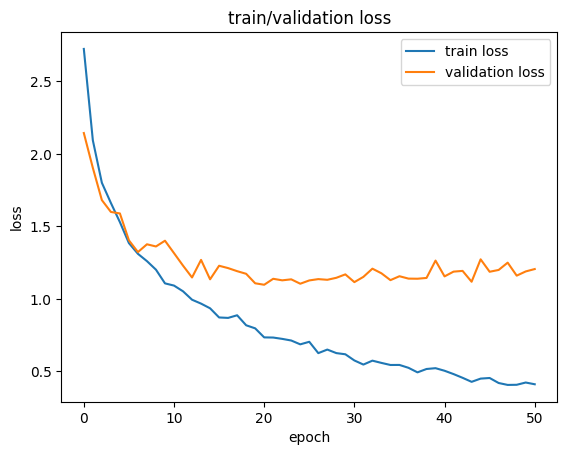

In [28]:
sns.lineplot(train_loss_list, label='train loss')
sns.lineplot(val_loss_list, label='validation loss')
plt.xlabel("epoch")
plt.ylabel('loss')
plt.title('train/validation loss')
plt.show()

In [29]:
test_df = pd.read_csv(os.path.join(data_path, './test.csv'))
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [30]:
test_img_paths = get_data(test_df, infer=True)

In [31]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

In [32]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()

    model_preds = []

    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.float().to(device)

            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()

    print('Done.')
    return model_preds

In [33]:
checkpoint = os.path.join(data_path, f'runs/{run_id}/best_model.pt')
print(f'CHECKPOINT LOADED: {checkpoint}')
infer_model = torch.load(checkpoint)
infer_model.to(device)
infer_model.eval()

CHECKPOINT LOADED: /content/drive/MyDrive/Project/CV/dataset/runs/0/best_model.pt


BaseModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1,

In [34]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/396 [00:00<?, ?it/s]

Done.


In [35]:
preds = le.inverse_transform(preds)

In [36]:
submit = pd.read_csv(os.path.join(data_path, './sample_submission.csv'))

In [37]:
submit['artist'] = preds

In [38]:
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Sandro Botticelli
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Vincent van Gogh


In [39]:
submit.to_csv(os.path.join(data_path, f"./submit_{CFG['FILENAME']}.csv"), index=False)